# Autre test

In [0]:
from google.colab import files

!pip install -q kaggle

In [0]:

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [0]:
!mkdir /root/.kaggle/ ; mv kaggle.json /root/.kaggle/
# !kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification
# !kaggle datasets download -d chetankv/dogs-cats-images
# !kaggle datasets download -d corentinminne/fruits-and-others
!kaggle datasets download -d corentinminne/tmp-fruit

 68% 17.0M/25.0M [00:00<00:00, 18.0MB/s]
100% 25.0M/25.0M [00:00<00:00, 28.6MB/s]


In [0]:
# !unzip fruits-fresh-and-rotten-for-classification.zip
# !unzip dogs-cats-images.zip
# !unzip fruits-and-others.zip
!unzip tmp-fruit.zip

Archive:  tmp-fruit.zip
  inflating: dataset_min/test/freshapples/Screen Shot 2018-06-08 at 5.09.54 PM.png  
  inflating: dataset_min/test/freshapples/Screen Shot 2018-06-08 at 5.14.01 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.08.05 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_45_Screen Shot 2018-06-08 at 5.05.18 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_45_Screen Shot 2018-06-08 at 5.10.11 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_60_Screen Shot 2018-06-08 at 4.59.57 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_60_Screen Shot 2018-06-08 at 5.04.16 PM.png  
  inflating: dataset_min/test/freshapples/rotated_by_75_Screen Shot 2018-06-08 at 5.18.37 PM.png  
  inflating: dataset_min/test/freshapples/saltandpepper_Screen Shot 2018-06-08 at 5.11.35 PM.png  
  inflating: dataset_min/test/freshapples/saltandpepper_Screen Shot 2018-06-08 at 5.22.48 PM.png  
  inflating: d

In [0]:
from IPython.core.interactiveshell import InteractiveShell

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import os

from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

InteractiveShell.ast_node_interactivity = 'all'

In [0]:

datadir = '/content/dataset_min'#'dataset'
traindir = datadir + '/train/'#'/training_set/'
validdir = datadir + '/test/'#'/test_set/'
testdir = datadir + '/test/'#'/test_set/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

batch_size = 128

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [0]:
# Empty lists
categories = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

n_classes = len(categories)

In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [0]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [0]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)

In [0]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [0]:
model = get_pretrained_model('vgg16')

In [0]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'freshapples'),
 (1, 'freshbanana'),
 (2, 'freshoranges'),
 (3, 'rottenapples'),
 (4, 'rottenbanana'),
 (5, 'rottenoranges')]

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=1,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 1.8178 	Validation Loss: 1.2073
		Training Accuracy: 18.33%	 Validation Accuracy: 80.00%

Best epoch: 1 with loss: 1.21 and acc: 80.00%
2.41 total seconds elapsed. 2.41 seconds per epoch.


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

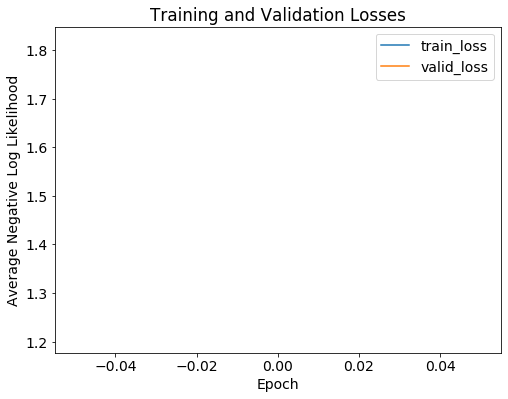

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

In [0]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [0]:
save_checkpoint(model, path=checkpoint_path)

In [0]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [0]:
model, optimizer = load_checkpoint(path=checkpoint_path)

135,310,918 total parameters.
1,050,374 total gradient parameters.


In [0]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    if img.shape[0] == 4:
      # print('=' * 30)
      img = img[:3]

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
def predict(image_path, model, topk=n_classes):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        print("model idx to class = ", model.idx_to_class)
        print("classe = ", [class_ for class_ in topclass.cpu().numpy()[0]])
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

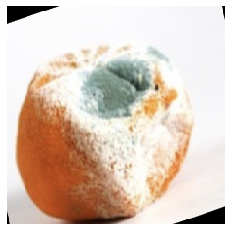

In [0]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(categories)
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index=classes)

    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

model idx to class =  {0: 'freshapples', 1: 'freshbanana', 2: 'freshoranges', 3: 'rottenapples', 4: 'rottenbanana', 5: 'rottenoranges'}
classe =  [2, 0, 5, 3, 1, 4]


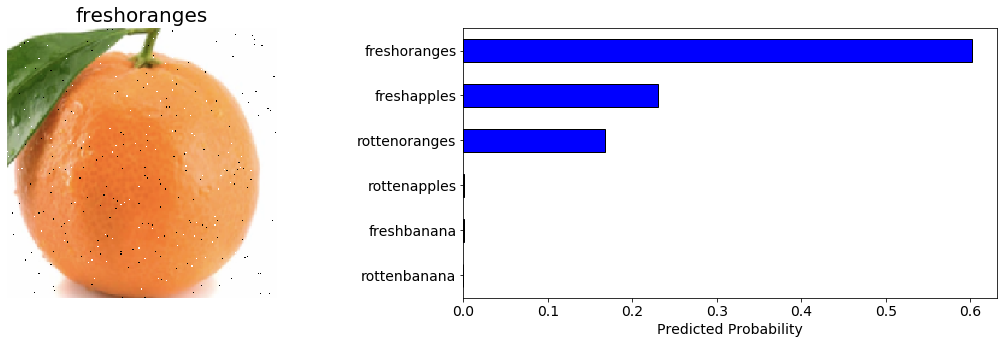

In [0]:
display_prediction(random_test_image(), model, topk=n_classes)